In [13]:
from pathlib import Path
import pandas as pd

pd.set_option("display.max_columns", None)  # Display all columns
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
import numpy as np
from sklearn.linear_model import LogisticRegression
from dataclasses import dataclass
from sklearn.metrics import (
    f1_score,
    auc,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
import shap

shap.initjs()
import xgboost as xgb
import dill as pickle

In [14]:
save_data_dir = Path(Path.cwd().parent, "data", "interim")
X_train = pd.read_pickle(Path(save_data_dir, "X_train.pkl"))
y_train = pd.read_pickle(Path(save_data_dir, "y_train.pkl"))
X_test = pd.read_pickle(Path(save_data_dir, "X_test.pkl"))
y_test = pd.read_pickle(Path(save_data_dir, "y_test.pkl"))

In [15]:
print(X_train.shape, y_train.shape)

(80000, 115) (80000,)


# Initial Thoughts
## Potential models
This is a binary classification task, and generally simpler models are best to start with. Therefore I will try logistic regression and a boosted decision tree initially and move on to more complex method if these do not give acceptable results. 

## Metrics
This is an imbalanced dataset, so useful metrics will be F1 score and ROC/AUC, as well as precision and recall. 

In [16]:
class MLModel:
    """
    Helper class to run various classifiers, undertake cross validation, 
    and save hyperparameters and metrics. 
    
    """

    def __init__(self, name, clf, X_train, y_train):
        self.name = name
        self.clf = clf
        self.X_train = X_train
        self.y_train = y_train

        self.scoring = {
            "AUC": "roc_auc",
            "Precision": "precision",
            "Recall": "recall",
            "F1": "f1",
        }

    def fit(self):

        self.full_scores = cross_validate(
            self.clf,
            self.X_train,
            self.y_train,
            scoring=self.scoring,
            cv=5,
            return_estimator=False,
        )
        self.scores = {k: np.mean(v) for k, v in self.full_scores.items()}

    def get_hyperparameters(self):
        self.hyperparameters = self.clf.get_params()

    def get_probabilities(self):
        self.probabilities = cross_val_predict(
            self.clf, self.X_train, self.y_train, cv=5, method="predict_proba"
        )

    def get_predictions(self):
        self.preds = cross_val_predict(
            self.clf, self.X_train, self.y_train, cv=5, method="predict"
        )

    def display_confusion_matrix(self):
        cm = confusion_matrix(self.y_train, self.preds, labels=np.array([0, 1]))
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=np.array([0, 1])
        )
        disp.plot()

    def run_all_metrics(self):
        self.fit()
        self.get_hyperparameters()
        self.get_probabilities()
        self.get_predictions()
        self.fitted_clf = self.clf.fit(X_train, y_train)

In [17]:
models_dict = {}

# Logistic Regeression
## No tuning, default params

In [18]:
clf = LogisticRegression(max_iter=1000)

LogRegDefault = MLModel(
    name="Logistic Regression default params", clf=clf, X_train=X_train, y_train=y_train
)
LogRegDefault.run_all_metrics()
models_dict[LogRegDefault.name] = LogRegDefault

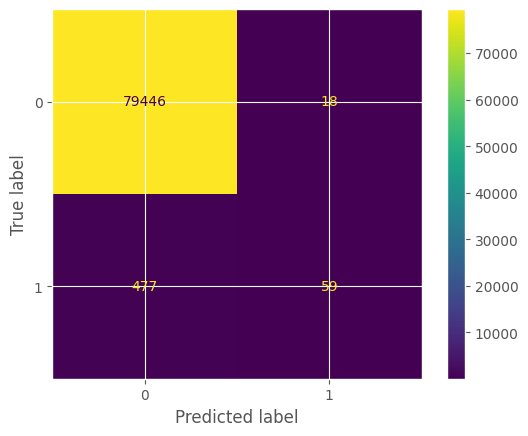

In [19]:
LogRegDefault.display_confusion_matrix()

In [20]:
LogRegDefault.scores

{'fit_time': 1.5619174480438232,
 'score_time': 0.05681467056274414,
 'test_AUC': 0.9231418468162194,
 'test_Precision': 0.7728571428571429,
 'test_Recall': 0.11008999653859466,
 'test_F1': 0.19219009167682788}

Iniitla results are poor, from the confusion matrix it is clear the classifier is essentially just predicting 0 for all examples - this is a common problem with imbalanced data. 

## Class Weights


In [21]:
clf = LogisticRegression(max_iter=1000, 
                         class_weight={0:y_train.value_counts()[0], 1: y_train.value_counts()[1]}, 
                         solver = 'newton-cholesky' # Adjusting solver bc lbfgs does not converge
                         )

LogRegDefaultClassWeights = MLModel(
    name="Logistic Regression default params with class weights", clf=clf, X_train=X_train, y_train=y_train
)
LogRegDefaultClassWeights.run_all_metrics()
models_dict[LogRegDefaultClassWeights.name] = LogRegDefaultClassWeights

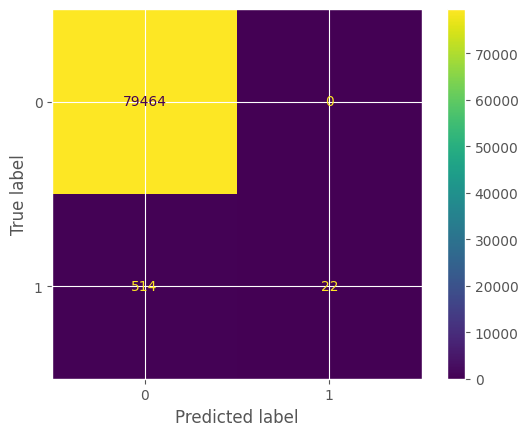

In [22]:
LogRegDefaultClassWeights.display_confusion_matrix()

In [23]:
LogRegDefaultClassWeights.scores

{'fit_time': 1.4621323585510253,
 'score_time': 0.04763517379760742,
 'test_AUC': 0.9514970246031396,
 'test_Precision': 1.0,
 'test_Recall': 0.0410349601938387,
 'test_F1': 0.07873690608203883}

Even worse! Let's see if we can do better with sampling

# Sampling. 

Since our F1 score is quite low I think hyperparameter tuning at this stage is pointless, as we would only expect a 5 - 10% increase in performance. 
At this point I'll try Under, over, and SMOTE sampling and check the results. 

NOTE The sampling methods can take anywhere from 5 - 10 mins each to run. 

## Under Sampling

In [24]:
clf = LogisticRegression(max_iter=1000)
cc = ClusterCentroids(random_state=0)
X_undersampled, y_undersampled = cc.fit_resample(X_train, y_train)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [25]:
# Inspecting the updated target feature counts
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_undersampled).items()))

[(0, 79464), (1, 536)]
[(0, 536), (1, 536)]


Under sampling reducing the number of examples in the majority class (0) to match that of the minority class (1). This is not ideal in our case as we lose around 99% of our data

In [26]:
LogRegDefaultUnderSampled = MLModel(
    name="Logistic Regression default params - undersampled",
    clf=clf,
    X_train=X_undersampled,
    y_train=y_undersampled,
)
LogRegDefaultUnderSampled.run_all_metrics()
models_dict[LogRegDefaultUnderSampled.name] = LogRegDefaultUnderSampled

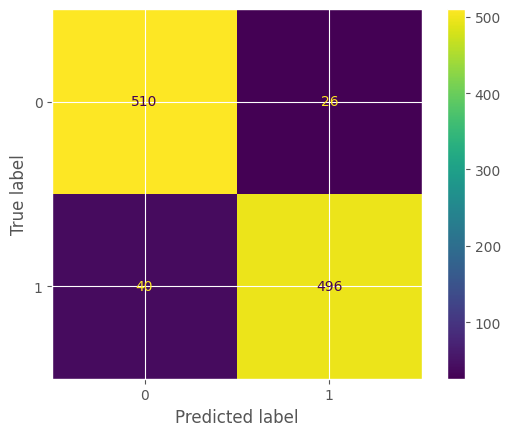

In [27]:
LogRegDefaultUnderSampled.display_confusion_matrix()

In [28]:
LogRegDefaultUnderSampled.scores

{'fit_time': 0.05980019569396973,
 'score_time': 0.04499940872192383,
 'test_AUC': 0.9835408559052545,
 'test_Precision': 0.9504710518074673,
 'test_Recall': 0.9254586362062998,
 'test_F1': 0.9375274354680853}

## Oversampling

In [29]:
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

In [30]:
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_oversampled).items()))

[(0, 79464), (1, 536)]
[(0, 79464), (1, 79464)]


Over sampling generates additional minority classes to balance out the data. Now we have arund 150,000 examples equally abalnced between 0 and 1. 
This technique is not ideal because the minority examples are merely copied over and over, our dataset does not gain any variety in examples

In [31]:
LogRegDefaultOverSampled = MLModel(
    name="Logistic Regression default params - oversampled",
    clf=clf,
    X_train=X_oversampled,
    y_train=y_oversampled,
)
LogRegDefaultOverSampled.run_all_metrics()
models_dict[LogRegDefaultOverSampled.name] = LogRegDefaultOverSampled

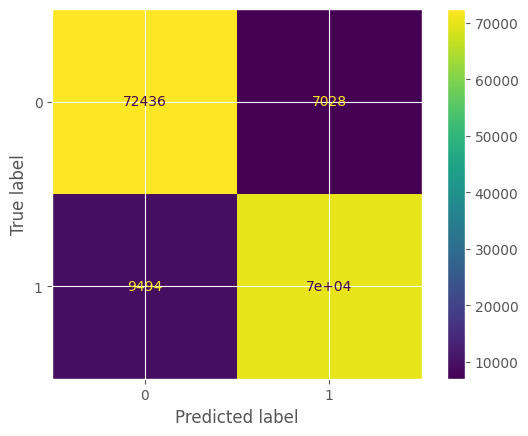

In [32]:
LogRegDefaultOverSampled.display_confusion_matrix()

In [33]:
LogRegDefaultOverSampled.scores

{'fit_time': 12.166745376586913,
 'score_time': 0.13845725059509278,
 'test_AUC': 0.954262883007894,
 'test_Precision': 0.9087255160235564,
 'test_Recall': 0.8805245734004981,
 'test_F1': 0.8943985767606243}

## SMOTE

In [34]:
smote_enn = SMOTEENN(random_state=0)
X_SMOTE, y_SMOTE = smote_enn.fit_resample(X_train, y_train)

In [35]:
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_oversampled).items()))

[(0, 79464), (1, 536)]
[(0, 79464), (1, 79464)]


SMOTE (Synthetic Minority Oversampling Technique) is an improved way of oversampling. It uses k nearest neighbours to create synthetic data points of the minority class. 

In [36]:
LogRegDefaultSMOTE = MLModel(
    name="Logistic Regression default params - oversampled",
    clf=clf,
    X_train=X_SMOTE,
    y_train=y_SMOTE,
)
LogRegDefaultSMOTE.run_all_metrics()
models_dict[LogRegDefaultSMOTE.name] = LogRegDefaultSMOTE

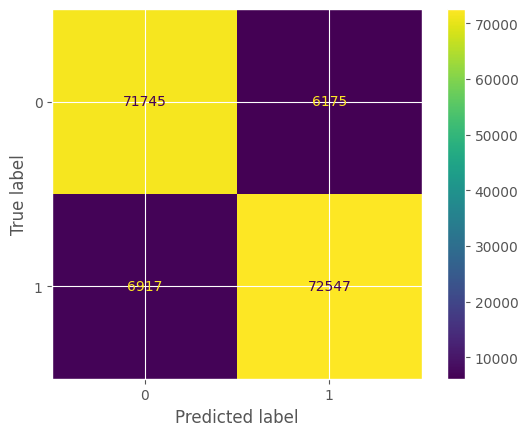

In [37]:
LogRegDefaultSMOTE.display_confusion_matrix()

In [38]:
LogRegDefaultSMOTE.scores

{'fit_time': 10.423921728134156,
 'score_time': 0.11400322914123535,
 'test_AUC': 0.9691703134428853,
 'test_Precision': 0.9215610688190751,
 'test_Recall': 0.9129543407492806,
 'test_F1': 0.9172343117291565}

# XGBoost

In [39]:
clf = xgb.XGBClassifier(tree_method="hist", eval_metric=f1_score)
XGBoostDefault = MLModel(
    name="XGBoost - default params",
    clf=clf,
    X_train=X_train,
    y_train=y_train,
)
XGBoostDefault.run_all_metrics()
models_dict[XGBoostDefault.name] = XGBoostDefault

{'fit_time': 2.0035891056060793, 'score_time': 0.12159962654113769, 'test_AUC': 0.9999492827141466, 'test_Precision': 0.9641904272018227, 'test_Recall': 0.9309968847352026, 'test_F1': 0.9468700013486693}


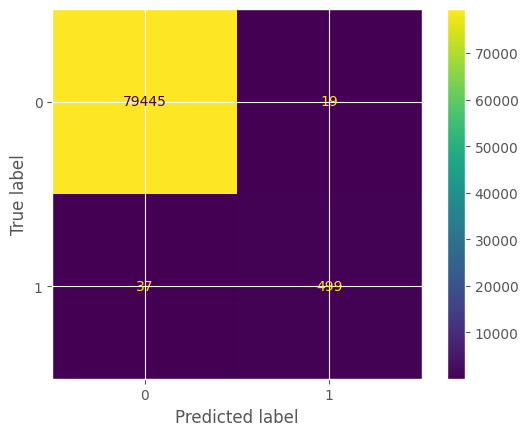

In [40]:
XGBoostDefault.display_confusion_matrix()
print(XGBoostDefault.scores)

Wow, XGBoost achieved scores comparable to logistic regression after sampling without any Over/under sampling. 
Not having to sample the data is preferable, as it is a slow process and using synthetic data is never optimal. 

I'm going to all the models run so far and pick up running some explainabiility tasks in the next notebook. 
Usually I would tune hyperparameters here but I don't have time unforutnaely. 

# Saving Models

In [41]:
save_trained_model_dir = Path(Path.cwd().parent, "models")
for k, v in models_dict.items():
    # v.__module__ = __name__
    with open(Path(save_trained_model_dir, str(k) + ".pkl"), "wb") as f:
        pickle.dump(v, file=f)